## This notebook validates the accuracy of the trained emulator `Speculator`

The `speculator` takes physical parameters and predict PCA coeffs (see `PCA_components_NMF.ipynb`) -> spectra -> magnitudes. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import torch
from torch import Tensor
from scipy.stats import norm

import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [132]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift

(10 params)

`beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)`

### Validate combined emulators

In [3]:
from popsed.speculator import SuperSpeculator
from popsed.models import lightspeed

In [12]:
params = np.load(f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.theta_unt.seedtest.npy')[:10000]
params = np.hstack([params[:, 1:], params[:, :1]])
# exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
print('Number of samples:', params.shape[0])

Number of samples: 10000


In [5]:
# slow
fspecs = [f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.log10spectrum.seedtest.npy']
logspec = np.load(fspecs[0])[:10000]
logspec = logspec.astype('float32')
logspec = logspec#[:, wave > 2000]

In [6]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
name = 'NMF'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol',
                 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'],
    device='cuda', use_speclite=True)

gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

### Emulation

In [91]:
# Emulator prediction
_specs = speculator._predict_spec_restframe(params)
_specs /= (lightspeed / torch.Tensor(wave**2).to('cuda'))

maggies = torch.trapezoid(
        ((speculator.wave_obs * _specs)[:, None, :] * speculator.transmission_effiency[None, :, :]
         ), speculator.wave_obs) / speculator.ab_zero_counts
maggies[maggies <= 0.] = 1e-15
mags = -2.5 * torch.log10(maggies).detach().cpu().numpy()

_specs = _specs.detach().cpu().numpy()

# calculate magnitudes based on the test spectra (generated by FSPS)
import speclite.filters
sdss = speclite.filters.load_filters('sdss2010-*')
sdss_mags = sdss.get_ab_magnitudes(10**logspec, wavelength=wave)
sdss_mags = np.hstack([sdss_mags[f'sdss2010-{filt}'][:, None] for filt in list('ugriz')])

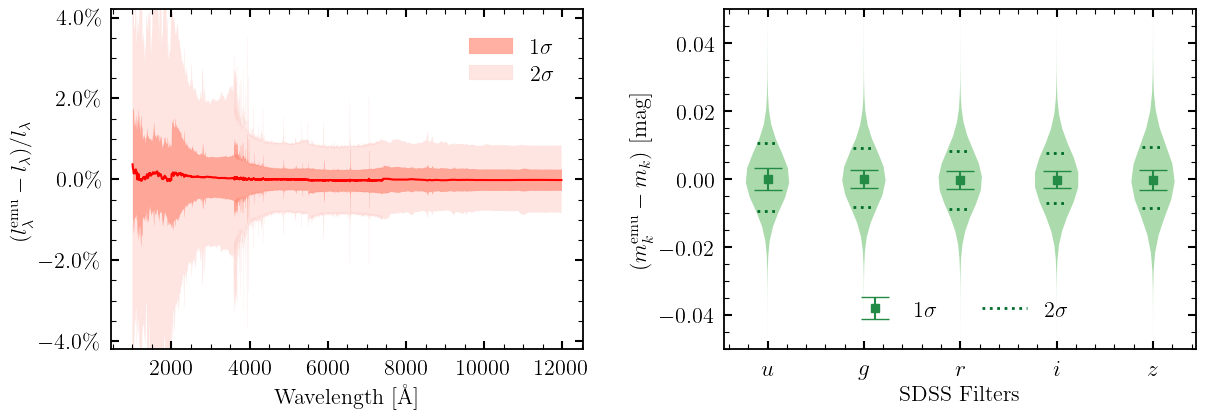

In [134]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

# Spec difference
diff = 100 * (10**logspec - _specs) / 10**logspec
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

for i_bin in range(1):
    plt.sca(axes[i_bin])
    if i_bin != 0:
        axes[i_bin].sharey(axes[i_bin-1])
    wave_bin = [
            (wave >= 1000) & (wave < 12000), 
            (wave >= 12000) & (wave < 60000)
            ][i_bin]
    x = wave[wave_bin]
    plt.plot(x, med_diff[wave_bin], color='r')
    plt.fill_between(x, 
                     diff_1sigma[0][wave_bin], 
                     diff_1sigma[1][wave_bin], 
                     alpha=0.5, lw=0.1, color='tomato', label='$1\sigma$')

    plt.fill_between(x, 
                     diff_2sigma[0][wave_bin], 
                     diff_2sigma[1][wave_bin], 
                     alpha=0.2, lw=0.1, color='salmon', label='$2\sigma$')
    plt.xlabel('Wavelength [$\mathrm{\AA}$]')
    plt.ylim(-4.2, 4.2)

plt.ticklabel_format(style='plain', axis='x')
axes[0].set_ylabel(r'$(l_{\lambda}^{\mathrm{emu}} - l_{\lambda})/l_{\lambda}$')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc='upper right')#, bbox_to_anchor=(-0.03, 1.))

plt.sca(axes[1])
ax = plt.gca()
diff = (mags - sdss_mags)
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

x = np.array([0, 1, 2, 3, 4])
plt.errorbar(x, med_diff, 
             yerr=[med_diff - diff_1sigma[0], 
                   diff_1sigma[1] - med_diff], 
             fmt='s', color='#238b45', capsize=10,
             label=r'$1\sigma$')
violin = plt.violinplot(diff, positions=x, 
                        showmedians=False, showextrema=False, 
                        quantiles=[[(1 - norm.cdf(2)), norm.cdf(2)] for i in range(5)],
                        widths=0.45,
                        points=1000
                       )
for pc in violin['bodies']:
    pc.set_facecolor('#74c476')
    pc.set_alpha(0.6)
violin['cquantiles'].set_color('#006d2c')
violin['cquantiles'].set_alpha(1.)
violin['cquantiles'].set_linestyle('dotted')
violin['cquantiles'].set_linewidth(2)
violin['cquantiles'].set_label(r'$2\sigma$')

ax.set_xticks(x)
ax.set_xticklabels([f'${ff}$' for ff in list('ugriz')], fontdict={'fontsize': 17})
ax.set_xlabel('SDSS Filters', labelpad=4)
ax.set_ylabel(r'$(m_k^{\mathrm{emu}} - m_k)$ [mag]')
ax.set_ylim(-0.05, 0.05)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           loc='lower center', ncol=2, frameon=False, 
           facecolor=None, shadow=False) 

plt.subplots_adjust(wspace=0.3)

plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/speculator_accuracy_NMF.png')

(90.0, 205.0)

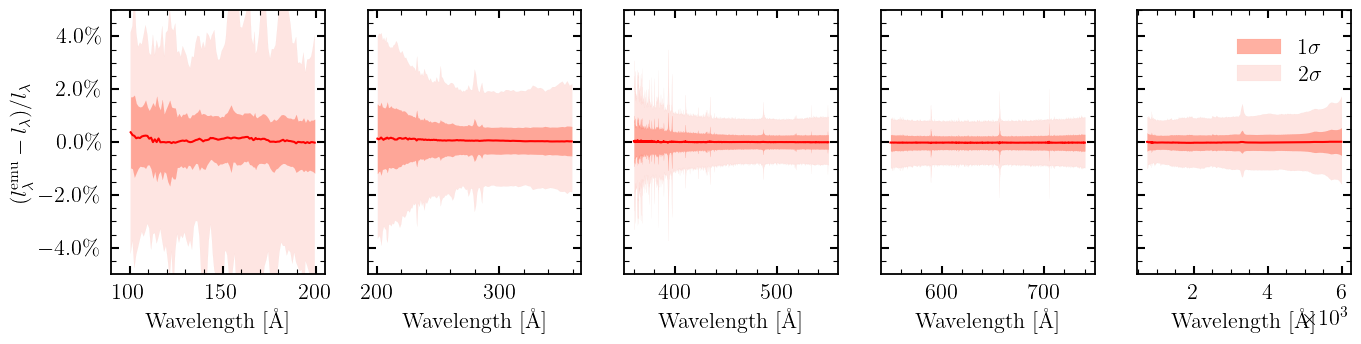

In [117]:
diff = 100 * (10**logspec - _specs) / 10**logspec
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 5, figsize=(16, 3.5), sharey=True)

for i_bin in range(5):
    plt.sca(axes[i_bin])
    wave_bin = [ 
            (wave >= 1000) & (wave < 2000), 
            (wave >= 2000) & (wave < 3600), 
            (wave >= 3600) & (wave < 5500), 
            (wave >= 5500) & (wave < 7410), 
            (wave >= 7410) & (wave < 60000)
            ][i_bin]
    x = wave[wave_bin] / 10
    plt.plot(x, med_diff[wave_bin], color='r')
    plt.fill_between(x, 
                     diff_1sigma[0][wave_bin], 
                     diff_1sigma[1][wave_bin], 
                     alpha=0.5, lw=0.1, color='tomato', label='$1\sigma$')

    plt.fill_between(x, 
                     diff_2sigma[0][wave_bin], 
                     diff_2sigma[1][wave_bin], 
                     alpha=0.2, lw=0.1, color='salmon', label='$2\sigma$')
    plt.xlabel('Wavelength [$\mathrm{\AA}$]')
#     plt.ylim(-2.5, 2.5)
    plt.ylim(-5, 5)
    
axes[0].set_ylabel(r'$(l_{\lambda}^{\mathrm{emu}} - l_{\lambda})/l_{\lambda}$')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[-1].legend(loc='upper right')#, bbox_to_anchor=(-0.03, 1.))
axes[0].set_xlim(90, 205)

# plt.savefig('/home/jiaxuanl/Research/popsed/figure/speculator_accuracy.png')

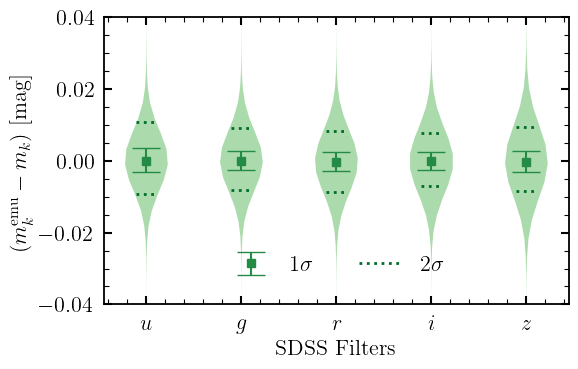

In [126]:
diff = (mags - sdss_mags)
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(6, 3.8))

x = np.array([0, 1, 2, 3, 4])

plt.errorbar(x, med_diff, 
             yerr=[med_diff - diff_1sigma[0], 
                   diff_1sigma[1] - med_diff], 
             fmt='s', color='#238b45', capsize=10,
             label=r'$1\sigma$')
        
violin = plt.violinplot(diff, positions=x, 
                        showmedians=False, showextrema=False, 
                        quantiles=[[(1 - norm.cdf(2)), norm.cdf(2)] for i in range(5)],
                        widths=0.45,
                        points=1000
                       )
for pc in violin['bodies']:
    pc.set_facecolor('#74c476')
    pc.set_alpha(0.6)
violin['cquantiles'].set_color('#006d2c')
violin['cquantiles'].set_alpha(1.)
violin['cquantiles'].set_linestyle('dotted')
violin['cquantiles'].set_linewidth(2)
violin['cquantiles'].set_label(r'$2\sigma$')


ax.set_xticks(x)
ax.set_xticklabels([f'${ff}$' for ff in list('ugriz')])
ax.set_xlabel('SDSS Filters')
ax.set_ylabel(r'$(m_k^{\mathrm{emu}} - m_k)$ [mag]')
ax.legend(loc='upper left', bbox_to_anchor=(-0.03, 1.))

plt.ylim(-0.04, 0.04)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           loc='lower center', ncol=2, frameon=False, 
           facecolor=None, shadow=False) 

# plt.savefig('/home/jiaxuanl/Research/popsed/figure/photulator_accuracy.png')

#### Try redshift

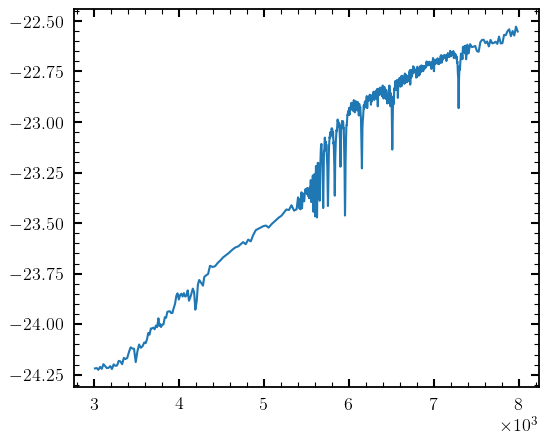

In [22]:
redshift_specs = torch.log10(speculator.predict_spec(params, 
                       log_stellar_mass=torch.ones(len(params), 1).to('cuda') * 10, 
                       redshift=torch.ones(len(params), 1).to('cuda') * 0.5))
flag = (speculator.wavelength < 8000) & (speculator.wavelength > 3000)
redshift_specs = redshift_specs[:, flag].cpu().detach().numpy()
plt.plot(speculator.wavelength[flag].cpu().numpy(), redshift_specs[5])